Testing logic with molecules.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

In [2]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy
from dgym.experiment import Experiment

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

In [6]:
# designer.design(res, 1, method='replace')

In [217]:
from tqdm.notebook import tqdm

reaction_compatibility = []
for reaction in tqdm(reactions):
    reaction_tree = {
        'reaction': reaction.name,
        'reactants': [{'method': 'random', 'seed': 10}, {'method': 'random', 'seed': 10}]
    }
    analogs = designer.construct_reaction(reaction_tree)

    results = []
    for _ in range(1_000):
        try:
            results.append(next(analogs))
        except:
            pass

    reaction_compatibility.append({
        'reaction': reaction.name,
        'num_compatible': len(set(results))
    })

  0%|          | 0/94 [00:00<?, ?it/s]

In [234]:
len(reaction_compatibility)

94

In [263]:
pd.DataFrame(reaction_compatibility).sort_values('num_compatible', ascending=False).to_csv('

[{'reaction': '13_Carboxylate_and_Amine', 'num_compatible': 493},
 {'reaction': '18_Halide_and_Amine', 'num_compatible': 485},
 {'reaction': '79_Stille', 'num_compatible': 473},
 {'reaction': '69_Negishi', 'num_compatible': 407},
 {'reaction': '87_Buchwald_Hartwig', 'num_compatible': 386},
 {'reaction': '23_Ester_and_Amine', 'num_compatible': 371},
 {'reaction': '81_Grignard_alcohol', 'num_compatible': 288},
 {'reaction': '83_Schotten_Baumann_amide', 'num_compatible': 285},
 {'reaction': '19_Halide_and_Alcohol', 'num_compatible': 244},
 {'reaction': '14_Carboxylate_and_Alcohol', 'num_compatible': 166},
 {'reaction': '80_Grignard_carbonyl', 'num_compatible': 112},
 {'reaction': '24_Ester_and_Alcohol', 'num_compatible': 87},
 {'reaction': '86_Wittig', 'num_compatible': 55},
 {'reaction': '52_1_2_4_triazole_carboxylic_acid_ester', 'num_compatible': 51},
 {'reaction': '64_oxadiazole', 'num_compatible': 34},
 {'reaction': '20_Halide_and_Thiol', 'num_compatible': 27},
 {'reaction': '66_reduc

Text(0.5, 1.0, 'Reaction compatibility: 1000 Enamine building block sets')

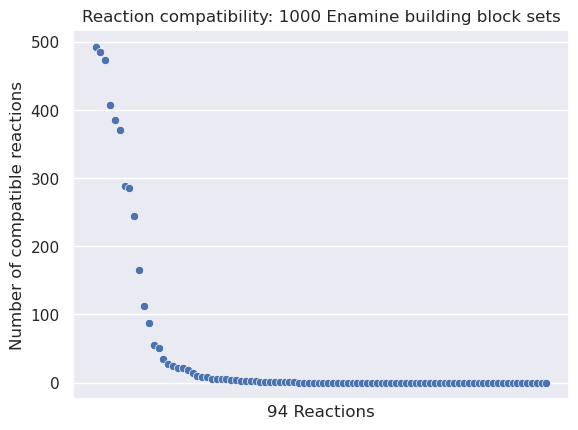

In [246]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.scatterplot(
    pd.DataFrame(reaction_compatibility)
    .sort_values('num_compatible', ascending=False)
    .reset_index(),
    x='reaction',
    y='num_compatible'
)
plt.xticks([])
plt.ylabel('Number of compatible reactions')
plt.xlabel('94 Reactions')
plt.title('Reaction compatibility: 1000 Enamine building block sets')

In [144]:
import pandas as pd

pd.DataFrame([m.reaction.name for m in mols]).value_counts()

13_Carboxylate_and_Amine          975
1_Epoxide_and_Alcohol              14
12_Carbonochloridate_and_Amine      5
2_Epoxide_and_Thiol                 4
5_Alkyne_and_Azide                  2
Name: count, dtype: int64

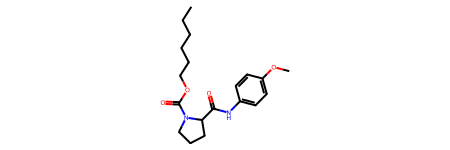

{'reaction': '12_Carbonochloridate_and_Amine', 'reactants': [{'product': 'COc1ccc(NC(=O)C2CCCN2)cc1.Cl'}, {'product': 'CCCCCCOC(=O)Cl'}]}


KeyboardInterrupt: 

In [118]:
designer.reset_cache()
display(res)
designer.design(res, 3, method='replace')[1]

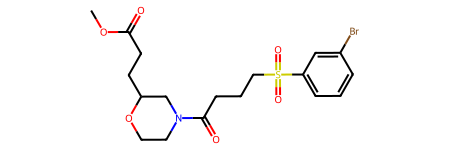

In [64]:
next(designer.construct_reaction(
    {'reaction': '13_Carboxylate_and_Amine', 'reactants': [{'product': 'COC(=O)CCC1CNCCO1.Cl'}, {'product': 'O=C(O)CCCS(=O)(=O)c1cccc(Br)c1'}]}
))

{'reaction': '1_Epoxide_and_Alcohol', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '2_Epoxide_and_Thiol', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '3_Alkene_Oxidized_To_Epoxide', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '4_Sulfonyl_Azide_and_Thio_Acid', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '5_Alkyne_and_Azide', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '6_Alcohol_To_Azide', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '7_Alcohol_To_Cyanide', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '8_Primary_Amine_Oxidized_To_an_Azide', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '9_Primary_Amine_Oxidized_To_an_Isocyanate', 'reactants': [{'method': 'random'}, {'method': 'random'}]}
{'reaction': '10_Primary_Amine_Oxidized_To_an_Isothiocyanate', 'reactants': [{'method

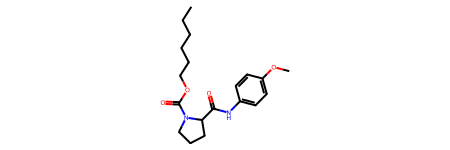

{'reaction': '12_Carbonochloridate_and_Amine', 'reactants': [{'product': 'COc1ccc(NC(=O)C2CCCN2)cc1.Cl'}, {'product': 'CCCCCCOC(=O)Cl'}]}


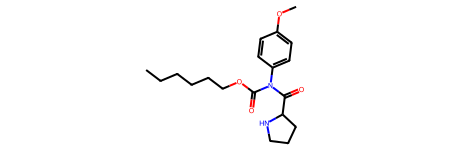

In [65]:
designer.reset_cache()
res = designer.design(1)[0]
display(res)
molecule = designer.design(molecule=res, size=1, method='replace')[0]
molecule

In [292]:
import json

print(json.dumps(molecule.dump(), indent=4))

{
    "product": "CC(=O)Nc1cc(NC(=O)c2cccc(C(=O)Nc3ccc(C(=O)N(C(=O)c4ccc(Cl)c(NC(=O)c5cnc6c(C)c(Cl)ccc6c5)c4)C(C)C)c(NC(C)=O)c3)c2)ccc1C(=O)O",
    "reaction": "13_Carboxylate_and_Amine",
    "reactants": [
        {
            "product": "Cc1c(Cl)ccc2cc(C(=O)Nc3cc(C(=O)NC(C)C)ccc3Cl)cnc12",
            "reaction": "13_Carboxylate_and_Amine",
            "reactants": [
                {
                    "product": "Cc1c(Cl)ccc2cc(C(=O)O)cnc12"
                },
                {
                    "product": "CC(C)NC(=O)c1ccc(Cl)c(N)c1"
                }
            ]
        },
        {
            "product": "CC(=O)Nc1cc(NC(=O)c2cccc(C(=O)Nc3ccc(C(=O)O)c(NC(C)=O)c3)c2)ccc1C(=O)O"
        }
    ]
}


In [293]:
import itertools

def construct_reaction(reaction_tree, generator):
    """
    Generates LazyReaction products based on a serialized reaction tree.
    
    Parameters:
    - serialized_tree: dict, the serialized reaction tree including SMILES strings.
    - generator: Generator object, used for generating molecules.
    
    Returns:
    - A generator for LazyReaction products.
    """
    # Base case: If tree is a simple molecule, return it appropriate generator
    if 'reactants' not in reaction_tree:
        product = reaction_tree.get('product', None)
        return generator(product, **reaction_tree)

    # Recursive case: Construct reactants and apply reaction
    if 'reaction' in reaction_tree \
        and 'reactants' in reaction_tree:
        reactants = [construct_reaction(reactant, generator) for reactant in reaction_tree['reactants']]
        reaction = reactions[reaction_tree['reaction']]
        return reaction.run(reactants)

    raise Exception('`reaction_tree` must include a reaction or reactants.')

CPU times: user 2.03 s, sys: 29.2 ms, total: 2.06 s
Wall time: 207 ms


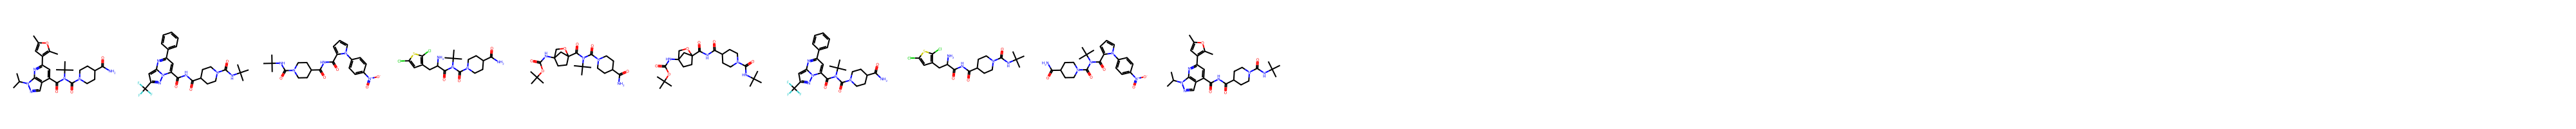

In [296]:
%%time
generator = Generator(building_blocks, fingerprints, sizes)
molecule = deck[1]
products = set()
size = 10

molecule.reaction = designer.match_reactions(molecule)[0]
reaction_tree = molecule.dump()

for reaction in reactions:

    if len(products) >= size:
        break

    reaction_tree_ = {
        'reaction': reaction.name,
        'reactants': [{'product': molecule.smiles}, {'mode': 'random'}]
    }
    analogs = construct_reaction(reaction_tree_, generator)
    
    for analog in analogs:
        analog.inspiration = molecule
        if len(products) < size:
            analog.reactants[0] = molecule
            products.add(analog)
        else:
            break

products = list(products)
from rdkit.Chem.Draw import MolsToGridImage

MolsToGridImage(
    [m.mol for m in products],
    molsPerRow=20,
)

Now, use "similar" strategy **after** a "grow" strategy.

In [297]:
products[4].dump()

{'product': 'CC(C)(C)OC(=O)NC12CCC(C(=O)N(C(=O)N3CCC(C(N)=O)CC3)C(C)(C)C)(C1)OC2',
 'reaction': '13_Carboxylate_and_Amine',
 'reactants': [{'product': 'CC(C)(C)NC(=O)N1CCC(C(N)=O)CC1',
   'reaction': '31_Isocyanate_and_Amine',
   'reactants': [{'product': 'NC(=O)C1CCNCC1'}, {'product': 'CC(C)(C)N=C=O'}]},
  {'product': 'CC(C)(C)OC(=O)NC12CCC(C(=O)O)(C1)OC2'}]}

In [358]:
2**31

2147483648

In [298]:
from itertools import combinations
from copy import deepcopy

def flatten_tree(reaction_tree, path=()):
    """
    Flattens the reaction tree to a list of paths to each reactant.

    Parameters
    ----------
    reaction_tree : dict
        The reaction tree to flatten.
    path : tuple
        The current path in the tree, used for internal tracking.

    Returns
    -------
    list
        A list of paths to each reactant in the tree.
    """
    if 'reactants' in reaction_tree and reaction_tree['reactants']:
        paths = []
        for i, reactant in enumerate(reaction_tree['reactants']):
            paths.extend(flatten_tree(reactant, path + (i,)))
        return paths
    else:
        return [path]

def apply_annotation_to_path(reaction_tree, path, method):
    """
    Applies an annotation to a reactant specified by a path.
    This function now utilizes deepcopy to ensure modifications are isolated.

    Parameters
    ----------
    reaction_tree : dict
        The reaction tree.
    path : tuple
        The path to the reactant to be annotated.
    mode : str
        The annotation mode.

    Returns
    -------
    dict
        The reaction tree with the annotation applied.
    """
    if not path:
        return {'product': reaction_tree['product'], 'method': method, **reaction_tree}

    reactants = reaction_tree['reactants']
    for i, step in enumerate(path):
        if i == len(path) - 1:
            reactants[step] = apply_annotation_to_path(reactants[step], (), method)
        else:
            reactants = reactants[step]['reactants']

    return reaction_tree

def annotate_reactants(reaction_tree, method: str = 'similar', num_annotations: int = 1):
    """
    Generates all unique variants of the reaction tree with the specified number of annotations applied.
    Utilizes deepcopy to ensure each variant is a completely separate copy.

    Parameters
    ----------
    reaction_tree : dict
        The initial reaction tree.
    mode : str
        The mode for annotation.
    num_annotations : int
        The number of annotations to apply.

    Returns
    -------
    list
        A list of all unique reaction tree variants with annotations applied.
    """
    paths = flatten_tree(reaction_tree)
    variants = []
    for combo in combinations(paths, num_annotations):
        new_tree = deepcopy(reaction_tree)
        for path in combo:
            new_tree = apply_annotation_to_path(new_tree, path, method)
        variants.append(new_tree)
    return variants

reaction_tree = molecule.dump()
variants = annotate_reactants(reaction_tree, method='similar', num_annotations=1)

In [299]:
import random

def generate_analogs(reaction_tree, method='similar', num_annotations=1):
    """Initialize the reaction system with a random configuration variant."""
    
    # Make variant reaction trees
    variant_trees = annotate_reactants(
        reaction_tree, method=method, num_annotations=num_annotations)
    variant_products = [
        construct_reaction(v, generator) for v in variant_trees]
    
    # Choose tree from which to yield product
    while True:
        chosen_products = random.choice(variant_products)
        yield from chosen_products

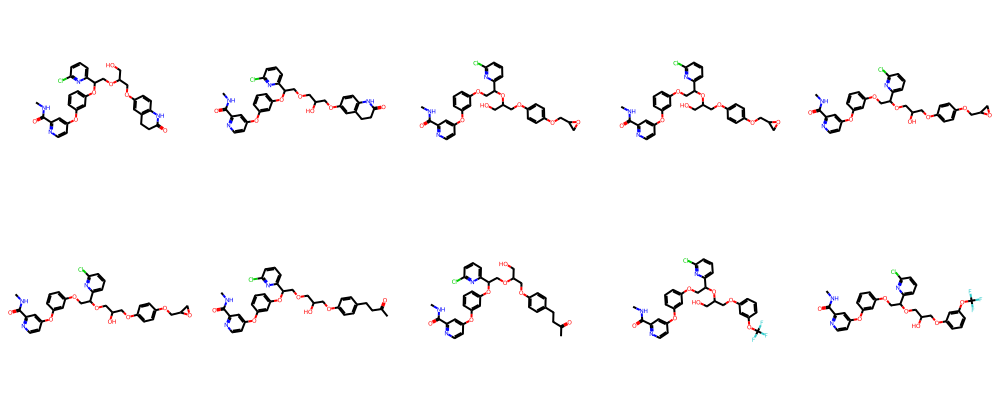

In [353]:
analogs = generate_analogs(molecule.dump(), method='similar')

MolsToGridImage(
    [next(analogs).mol for _ in range(10)],
    molsPerRow=5,
)